<h1>FINAL ASSIGNMENT</h1>
<br>

<h2>INTRODUCTION</h2>
<hr>

<p>During the COVID-19 pandemic, someone who needs to choose a neighborhood in the city of Rio de Janeiro to live, may question which areas are safe or not. In this final assignment, we are going to visualize each neighborhood of Rio de Janeiro by the COVID-19 death rate and the distribution of the city's medical infrastructure.</p>
<p>This is just one criteria amongst many others that are related to death or recovery cases of infected people.</p>
<p>As this study progresses, we will discover that good medical infrastructure in certain areas can help, as expected, in the recovery of patients. On the other hand, the lack of proper medical care can directly influence on a larger death count.</p>

<h2>DATA</h2>
<hr>

<p>The geospatial data, as well the COVID cases data, are from official institutions of the local government. The datasets can be obtained in the following URLs:</p>

<li><a href=http://dadosabertos.rio.rj.gov.br/apiUrbanismo/apresentacao/csv/bairros_.csv>http://dadosabertos.rio.rj.gov.br/apiUrbanismo/apresentacao/csv/bairros_.csv<a/></li>
<li><a href=https://www.data.rio/datasets/cep-dos-casos-confirmados-de-covid-19-no-munic%C3%ADpio-do-rio-de-janeiro>https://www.data.rio/datasets/cep-dos-casos-confirmados-de-covid-19-no-munic%C3%ADpio-do-rio-de-janeiro</a></li>
<li><a href=https://www.data.rio/datasets/limite-de-bairros?geometry=-44.899%2C-23.138%2C-41.992%2C-22.695>https://www.data.rio/datasets/limite-de-bairros?geometry=-44.899%2C-23.138%2C-41.992%2C-22.695 (The geoson file with the neighborhood limits)</a></li>

<h3>Importing libraries, initializing variables and preparing the input data</h3>

In [20]:
# Importing the required libraries
from geopy.geocoders import Nominatim
import folium
# library to build a legend on the map
from branca.element import Template, MacroElement
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import json

# Foursquare credentials
CLIENT_ID = 'CRN2QP54XJ4SSKPST0LYZTLSISLNWRJVAMKSBNP5ULMO5Q0C' # your Foursquare ID
CLIENT_SECRET = 'FGZOZCDZ5LUQVECCPKW3BI2RSWRTOAWRWQW0IVFH2ZZT4T1D' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

# Rio de Janeiro Map initial information
address = 'Rio de Janeiro, BR'

geolocator = Nominatim(user_agent="rio_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# Rio de Janeiro geospatial data of each neighborhood
# from: http://dadosabertos.rio.rj.gov.br/apiUrbanismo/apresentacao/csv/bairros_.csv
# The file was converted from Windows Ansi to UTF-8 CSV and the first row was removed on Excel. The new file was saved as bairros_finall.csv
dfRio = pd.read_csv('bairros_final.csv')
# Converting the latitude and longitude data to string
dfRio['Latitude'] = dfRio['Latitude'].apply(str)
dfRio['Longitude'] = dfRio['Longitude'].apply(str)
# Removing all the special chars and accents and converting everything to uppercase
dfRio['Bairro'] = dfRio['Bairro'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('ascii').str.upper()
# Renaming the first column to Neighborhood (Bairro means Neighborhood in Portuguese - BR)
dfRio.rename(columns={"Bairro":"Neighborhood"}, inplace=True)

# Data from Coronavirus incidence in each neighborhood of Rio de Janeiro
# from: https://www.data.rio/datasets/cep-dos-casos-confirmados-de-covid-19-no-munic%C3%ADpio-do-rio-de-janeiro
rioCovid = pd.read_csv('Dados_CEP_MRJ_covid_19.csv', sep=';')

# Read geoson file with the neighborhood limits and import the neighborhood id to a new dataframe.
# This dataframe will be merged with the main dataframe (dfRioData) to make a choropleth map later
with open('Limite_de_Bairros.geojson', 'r') as geoson_file:
    jsonFile = geoson_file.read()

# Parse file
jsonObj = json.loads(jsonFile)

# Create the new Dataframe
dfNeighborhoodID = pd.DataFrame(columns=['ID', 'Neighborhood'], index=range(len(jsonObj['features'])))

for i in range(len(jsonObj['features'])):
    dfNeighborhoodID.loc[i].ID = jsonObj['features'][i]['properties']['OBJECTID']
    dfNeighborhoodID.loc[i].Neighborhood = jsonObj['features'][i]['properties']['NOME']

# Removing all the special chars and accents and converting everything to uppercase
dfNeighborhoodID['Neighborhood'] = dfNeighborhoodID['Neighborhood'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('ascii').str.upper()

# Verifying which Neighborhoods does not match because of mispellings
#rioNeighborhood = pd.merge(dfNeighborhoodID, dfRio, on='Neighborhood', how='outer')
# Bras de Pina, Oswaldo Cruz and Vila Cosmos are the neighborhoods that need correction, so let's do it
dfRio.replace('BRAZ DE PINA', 'BRAS DE PINA', inplace=True)
dfRio.replace('OSWALDO CRUZ', 'OSVALDO CRUZ', inplace=True)
dfRio.replace('VILA COSMOS', 'VILA KOSMOS', inplace=True)

# Merge the dataframes
rioNeighborhood = pd.merge(dfNeighborhoodID, dfRio, on='Neighborhood')

# Checking if there is any NaN values
#print(rioNeighborhood[rioNeighborhood['ID'].isna()])
#rioNeighborhood[rioNeighborhood['Latitude'].isna()]   

<h3>Data Cleansing and Creating the final dataframe</h3>
<p>This dataframe will be used in the clustering process and in the Foursquare exploratory analysis</p>
<p>Regarding the COVID status: all cases that are active will be removed from the dataframe since we can't be assure how many will recover or not from the disease. The total cases in the neighborhood will consider the sum of deaths and recoveries and from this point, we can calculate the death rate and recovery rate from each neighborhood. With this metodology, the neighborhood population is not relevant because the rates already includes it implicitily.</p>

In [2]:
# Dropping some columns and renaming the others
rioCovid.drop(['dt_notific', 'dt_inicio_sintomas', 'ap_residencia_estadia', 'dt_evolucao', 'cep', 'data_atualizacao'], axis=1, inplace = True)
rioCovid.rename(columns={"bairro_resid__estadia":"Neighborhood","dt_notific":"Date", "evolucao":"Status"}, inplace=True)

# Translating the status values from portuguese to english
# First, let's list all the status values
status = rioCovid['Status'].unique()
# The values are: 'OBITO', 'RECUPERADO', 'ATIVO'
statusDict = {"OBITO":"Death", "RECUPERADO":"Recovered", "ATIVO":"Active"}
rioCovid.replace({"Status":statusDict}, inplace=True)

# Hot encoding the Status column
covid_onehot = pd.get_dummies(rioCovid[['Status']], prefix="", prefix_sep="")
dfRioCovid = pd.merge(rioCovid, covid_onehot, left_index=True, right_index=True)

# Dropping the Active and Status columns that are not be considered in the final study
dfRioCovid.drop(['Status', 'Active'], axis=1, inplace = True)

# Grouping the data by Neighborhood
dfRioCovid = dfRioCovid.groupby('Neighborhood').sum().reset_index()

# Calculating the rate of recoveries and deaths (total cases = (Deaths + Recoveries), Death Rate = Deaths/Total Cases, Recovery Rate = Recoveries/Total Cases)
dfRioCovid['Total Cases'] = dfRioCovid['Death'] + dfRioCovid['Recovered']
dfRioCovid['Death Rate'] = dfRioCovid['Death']/dfRioCovid['Total Cases']
dfRioCovid['Recovery Rate'] = dfRioCovid['Recovered']/dfRioCovid['Total Cases']

# Merging the Covid dataframe with the Neighborhood dataframe
# First, let's verify again which Neighborhoods does not match because of mispellings
#dfRioData = pd.merge(rioNeighborhood, dfRioCovid, on='Neighborhood', how='outer')

# Checking if there is any NaN values
#print(dfRioData[dfRioData['ID'].isna()])
#dfRioData[dfRioData['Death'].isna()]

# From the test above, there are two Neighborhoods from the Covid source that doesn't exist in the Neighborhood dataframe ('Fora do Municipio' and 'Vila Kennedy'). There are 5 others that need
# corrections in the COVID DF duo to mispellings: 'Cavalcanti', 'Freguesia (Ilha)', 'Freguesia (Jacarepagua)', 'Osvaldo Cruz' and 'Ricardo de Albuquerque'. We need to correct them.
neighDict = {"CAVALCANTE":"CAVALCANTI", "RICARDO ALBUQUERQUE":"RICARDO DE ALBUQUERQUE", "OSWALDO CRUZ":"OSVALDO CRUZ", "FREGUESIA-ILHA":"FREGUESIA (ILHA)", "FREGUESIA-JPA":"FREGUESIA (JACAREPAGUA)"}
dfRioCovid.replace({"Neighborhood":neighDict}, inplace=True)

# That's the final dataframe that will be use throughout the study
dfRioData = pd.merge(rioNeighborhood, dfRioCovid, on='Neighborhood')

dfRioData.head()

ID      Neighborhood             Latitude           Longitude  Death  \
0  325           PAQUETA          -22.7597222         -43.1088889    8.0   
1  326  FREGUESIA (ILHA)  -22.786389399999997         -43.1722945   40.0   
2  327         BANCARIOS          -22.7959138          -43.175927   24.0   
3  328            GALEAO          -22.8091667         -43.2380556   36.0   
4  330        PORTUGUESA  -22.798892300000002  -43.20618839999999   50.0   

   Recovered  Total Cases  Death Rate  Recovery Rate  
0      160.0        168.0    0.047619       0.952381  
1      253.0        293.0    0.136519       0.863481  
2      254.0        278.0    0.086331       0.913669  
3      683.0        719.0    0.050070       0.949930  
4      460.0        510.0    0.098039       0.901961

In [3]:
# Create a column with the death rate in percentual format
dfRioData['Death Rate(%)'] = dfRioData['Death Rate']*100

# Showing the neighborhoods with the largest death rate (considering more than 1000 cases)
rioCovidDeath = dfRioData.sort_values(by='Death Rate', ascending=False).head(50)
rioCovidDeath[rioCovidDeath['Total Cases'] > 1000]

ID    Neighborhood     Latitude            Longitude  Death  Recovered  \
54   378    PADRE MIGUEL  -22.8833333               -43.45  207.0      950.0   
159  511           BANGU   -22.883333           -43.466667  634.0     3517.0   
123  450       GUARATIBA  -22.9984858          -43.5799151  215.0     1206.0   
63   389  SENADOR CAMARA  -22.8666667                -43.5  224.0     1273.0   
6    370        REALENGO  -22.8833333          -43.4333333  492.0     2906.0   
158  510    CAMPO GRANDE     -22.8825             -43.5625  943.0     5716.0   
29   356       GUADALUPE  -22.8372222          -43.3752778  140.0      959.0   
82   406          COSMOS  -22.9166667          -43.6166667  129.0      927.0   
31   351    BRAS DE PINA  -22.8316343  -43.293239299999996  150.0     1082.0   
15   337          PAVUNA  -22.8136111          -43.3602778  164.0     1232.0   
58   384      SANTISSIMO   -22.883333           -43.516667  104.0      899.0   

     Total Cases  Death Rate  Recovery Rate  Death Rate(%)  
54        1157.0    0.178911       0.821089      17.891098  
159       4151.0    0.152734       0.847266      15.273428  
123       1421.0    0.151302       0.848698      15.130190  
63        1497.0    0.149633       0.850367      14.963260  
6         3398.0    0.144791       0.855209      14.479105  
158       6659.0    0.141613       0.858387      14.161285  
29        1099.0    0.127389       0.872611      12.738854  
82        1056.0    0.122159       0.877841      12.215909  
31        1232.0    0.121753       0.878247      12.175325  
15        1396.0    0.117479       0.882521      11.747851  
58        1003.0    0.103689       0.896311      10.368893

<hr>
<p>We see above that most of the neighborhoods that are in worse conditions are located in the west zone of the city.</p>
<p>This is a low income, high density area. For diseases that spread rapidily, like COVID-19, those areas need special attention from the autorithies.
    Further, we will see, using Foursquare API, how is the medical infrastructure in the region.</p>
<hr>

<h3>Using Foursquare to analyze the venues and cluster the neighborhoods by the medical category</h3>
<p>Those are the IDs of the three categories that will be used, primarily:</p>
<li>Hospital ID on Foursquare: 4bf58dd8d48988d196941735</li>
<li>Emergency Room ID on Foursquare: 4bf58dd8d48988d194941735</li>
<li>Urgente Care Center ID on Foursquare: 56aa371be4b08b9a8d573526</li>
<hr>
<h5>The function below explore venues in a certain category, specified as a parameter (a slightly modified version the function used in the course)</h5>

In [4]:
def getNearbyCategoryVenues(names, latitudes, longitudes, category, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?categoryId={}&intent=browse&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            category,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
        print(url)
            
        # make the GET request
        results = requests.get(url).json()["response"]['venues']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [5]:
# Those are the categories of hospitals, emergency rooms and urgent care centers
rio_venues = getNearbyCategoryVenues(dfRioData.Neighborhood, dfRioData.Latitude, dfRioData.Longitude, '4bf58dd8d48988d196941735,4bf58dd8d48988d194941735,56aa371be4b08b9a8d573526 ')

# one hot encoding
rio_onehot = pd.get_dummies(rio_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
rio_onehot['Neighborhood'] = rio_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [rio_onehot.columns[-1]] + list(rio_onehot.columns[:-1])
rio_onehot = rio_onehot[fixed_columns]

rio_onehot.head()

PAQUETA
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d196941735,4bf58dd8d48988d194941735,56aa371be4b08b9a8d573526 &intent=browse&client_id=CRN2QP54XJ4SSKPST0LYZTLSISLNWRJVAMKSBNP5ULMO5Q0C&client_secret=FGZOZCDZ5LUQVECCPKW3BI2RSWRTOAWRWQW0IVFH2ZZT4T1D&v=20180605&ll=-22.7597222,-43.1088889&radius=500&limit=100
FREGUESIA (ILHA)
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d196941735,4bf58dd8d48988d194941735,56aa371be4b08b9a8d573526 &intent=browse&client_id=CRN2QP54XJ4SSKPST0LYZTLSISLNWRJVAMKSBNP5ULMO5Q0C&client_secret=FGZOZCDZ5LUQVECCPKW3BI2RSWRTOAWRWQW0IVFH2ZZT4T1D&v=20180605&ll=-22.786389399999997,-43.1722945&radius=500&limit=100
BANCARIOS
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d196941735,4bf58dd8d48988d194941735,56aa371be4b08b9a8d573526 &intent=browse&client_id=CRN2QP54XJ4SSKPST0LYZTLSISLNWRJVAMKSBNP5ULMO5Q0C&client_secret=FGZOZCDZ5LUQVECCPKW3BI2RSWRTOAWRWQW0IVFH2ZZT4T1D&v=20180605&ll=-22.7959138,-43.175927&r

Neighborhood  Doctor's Office  Emergency Room  Hospital  Medical Center  \
0       BANCARIOS                0               0         1               0   
1        REALENGO                0               0         1               0   
2            TAUA                0               0         1               0   
3            TAUA                0               0         1               0   
4  JARDIM AMERICA                0               0         0               0   

   Urgent Care Center  
0                   0  
1                   0  
2                   0  
3                   0  
4                   1

In [6]:
# Gouping the venues by quantity. We want to know how is the medical infrastructure in each neighborhood. The clustering will be based on this information
rio_grouped = rio_onehot.groupby('Neighborhood').sum().reset_index()
rio_grouped

Neighborhood  Doctor's Office  Emergency Room  Hospital  \
0           ANDARAI                0               0         2   
1         BANCARIOS                0               0         1   
2             BANGU                0               0         4   
3   BARRA DA TIJUCA                0               0         1   
4           BENFICA                0               0        16   
..              ...              ...             ...       ...   
76          VIDIGAL                0               0         0   
77    VIGARIO GERAL                0               1         0   
78      VILA ISABEL                0               0         2   
79   VILA VALQUEIRE                0               0         3   
80            ZUMBI                0               1         2   

    Medical Center  Urgent Care Center  
0                0                   0  
1                0                   0  
2                0                   0  
3                0                   0  
4                0                   0  
..             ...                 ...  
76               0                   1  
77               0                   0  
78               0                   0  
79               0                   0  
80               0                   0  

[81 rows x 6 columns]

<h3>Clustering the data with the Foursquare information</h3>

In [7]:
# set number of clusters
kclusters = 3

rio_grouped_clustering = rio_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans2 = KMeans(n_clusters=kclusters, random_state=0).fit(rio_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans2.labels_[0:10] 


array([2, 2, 0, 2, 1, 2, 1, 2, 2, 2], dtype=int32)

In [8]:
# add clustering labels
rio_grouped.insert(0, 'Cluster Labels', kmeans2.labels_)

# Dataframe that will be used in the map below
rio_merged = pd.merge(dfRioData, rio_grouped, on='Neighborhood')
rio_merged.head()

ID    Neighborhood     Latitude           Longitude  Death  Recovered  \
0  327       BANCARIOS  -22.7959138          -43.175927   24.0      254.0   
1  370        REALENGO  -22.8833333         -43.4333333  492.0     2906.0   
2  329            TAUA     -22.7975  -43.18555560000001   46.0      430.0   
3  335  JARDIM AMERICA  -22.8105556  -43.32333329999999   63.0      570.0   
4  425           SAUDE  -22.8976866         -43.1856126    2.0       76.0   

   Total Cases  Death Rate  Recovery Rate  Death Rate(%)  Cluster Labels  \
0        278.0    0.086331       0.913669       8.633094               2   
1       3398.0    0.144791       0.855209      14.479105               2   
2        476.0    0.096639       0.903361       9.663866               2   
3        633.0    0.099526       0.900474       9.952607               2   
4         78.0    0.025641       0.974359       2.564103               1   

   Doctor's Office  Emergency Room  Hospital  Medical Center  \
0                0               0         1               0   
1                0               0         1               0   
2                0               0         2               0   
3                0               0         0               0   
4                0               2        14               0   

   Urgent Care Center  
0                   0  
1                   0  
2                   0  
3                   1  
4                   0

<h3>Studying the clusters properties</h3>
<p>Grouping the data by the cluster labels and running the code below, wich results in a dataframe sorted by the Death Rate, we distinguish (worst first) the following order: 2, 0 and 1.</p>
<p>We can also note that the quantity of hospitals are in a reverse order comparing to the death rate column.</p>

In [9]:
# Grouping the cluster dataframe by Cluster Labels, using the mean values
dfRioCluster = rio_merged.groupby("Cluster Labels").mean().reset_index().sort_values("Death Rate", ascending=False)

# Creating a column to the total of medical venues
dfRioCluster['Total Infra'] = dfRioCluster["Doctor's Office"] + dfRioCluster['Emergency Room'] + dfRioCluster['Hospital'] + dfRioCluster['Medical Center'] + dfRioCluster['Urgent Care Center']

dfRioCluster['Cluster Labels'] = dfRioCluster['Cluster Labels'].astype(str)
dfRioCluster

Cluster Labels       Death    Recovered  Total Cases  Death Rate  \
2              2  101.406250  1177.203125  1278.609375    0.088240   
0              0  132.636364  1288.727273  1421.363636    0.078337   
1              1   81.000000  1541.166667  1622.166667    0.052210   

   Recovery Rate  Death Rate(%)  Doctor's Office  Emergency Room   Hospital  \
2       0.911760       8.824015         0.015625        0.375000   1.265625   
0       0.921663       7.833678         0.181818        0.727273   6.272727   
1       0.947790       5.221032         0.000000        1.500000  15.333333   

   Medical Center  Urgent Care Center  Total Infra  
2        0.000000            0.109375     1.765625  
0        0.000000            0.090909     7.272727  
1        0.333333            0.166667    17.333333

<h3>Visualizing the cluster data</h3>

<h4>Bar Plot showing the death rate for each cluster</h4>
<p><b>Important</b>: the K-Means algorithm does not consider the COVID cases in its training, only the medical infrastructure (as seen in the cells above).</p>
<p>Without further calculations, the visualization bellow shows that there is some sort of correlation between the medical infrastructure of neighborhood and the death rate by COVID, as expected.</p>

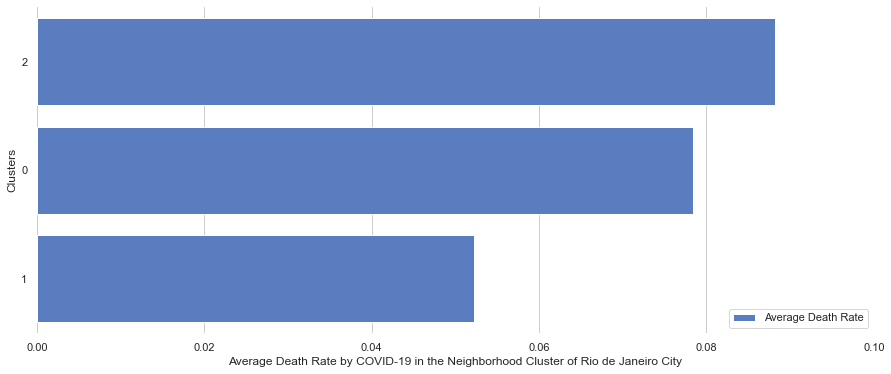

In [10]:
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 6))

# Plot the Death Mean in the Cluster
sns.set_color_codes("muted")
sns.barplot(x="Death Rate", y="Cluster Labels", data=dfRioCluster,
            label="Average Death Rate", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="best", frameon=True)
ax.set(xlim=(0, 0.1), ylabel="Clusters",
       xlabel="Average Death Rate by COVID-19 in the Neighborhood Cluster of Rio de Janeiro City")
sns.despine(left=True, bottom=True)

<h4>Bar Plot showing the quantity of hospitals and total medical infrastructure in each cluster</h5>

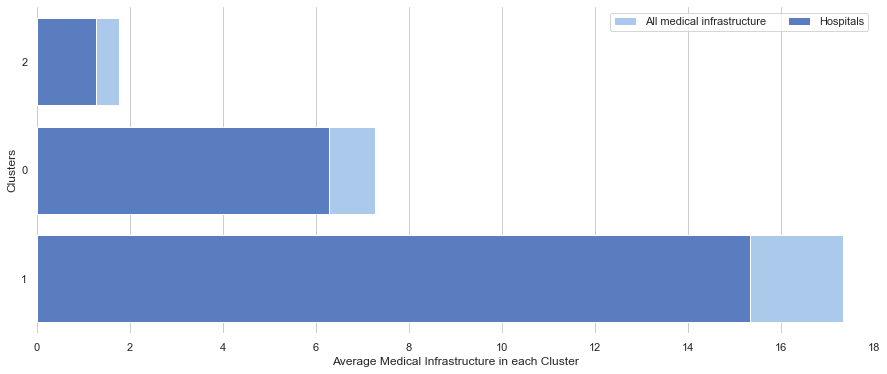

In [11]:
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 6))

# Plot the Total Cases Mean in the Cluster
sns.set_color_codes("pastel")
sns.barplot(x="Total Infra", y="Cluster Labels", data=dfRioCluster,
            label="All medical infrastructure", color="b")

# Plot the Death Mean in the Cluster
sns.set_color_codes("muted")
sns.barplot(x="Hospital", y="Cluster Labels", data=dfRioCluster,
            label="Hospitals", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="best", frameon=True)
ax.set(xlim=(0, 18), ylabel="Clusters",
       xlabel="Average Medical Infrastructure in each Cluster")
sns.despine(left=True, bottom=True)

<h3>Discussing the results, considering the initial observations:</h3>
<li>Cluster 2 has the <b>larger</b> death rate and <b>worst</b> medical infrastructure overall</li>
<li>Cluster 0 has a medium death rate and average medical infrastructure, with few hospitals</li>
<li>Cluster 1 has the <b>smallest</b> death rate and <b>best</b> medical infrastructure of all above</li>

<h3>Choropleth Map considering the Death Rate(%) of each Neighborhood and the Clustering Markers indicating their Medical Infrastructure</h3>
<p>The color of the clusters are the following:</p>
<li><font color='orange'>Cluster 0</font>: being the cluster with the average medical infra, its color is <b>orange</b></li>
<li><font color='green'>Cluster 1</font>: since it has the best medical infra, its color is <b>green</b></li>
<li><font color='red'>Cluster 2</font>: the worst cluster overall, its color is <b>red</b></li>
<p>There are two neighborhoods with missing information regarding COVID-19 cases: Jabour and Vila Kennedy. They appear in the color black on the map.</p>


In [23]:
rio_geo = 'Limite_de_Bairros.geojson'

# This is an html template to build a draggable legend on the map
template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Map Markers Legend (draggable)</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:red;opacity:0.7;'></span>Cluster 2 - Worst Medical Infra</li>
    <li><span style='background:orange;opacity:0.7;'></span>Cluester 0 - Avg Medical Infra</li>
    <li><span style='background:green;opacity:0.7;'></span>Cluster 1 - Best Medical Infra</li>

  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

# -22.903912, -43.428555 Coordinates in the center of the map

map_clusters = folium.Map(location=[-22.903912,  -43.428555], zoom_start=12)

folium.Choropleth(
    geo_data=rio_geo,
    name='choropleth',
    data=dfRioData,
    columns=['ID', 'Death Rate(%)'],
    key_on='feature.properties.OBJECTID',
    #fill_color='YlOrRd',
    fill_color='BuPu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Death Rate(%)'
).add_to(map_clusters)

# add markers to the map
for lat, lon, poi, cluster in zip(rio_merged['Latitude'], rio_merged['Longitude'], rio_merged['Neighborhood'], rio_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    if cluster == 1:
        iconColor = folium.Icon(color='green')
    elif cluster == 2:
        iconColor = folium.Icon(color='red')
    else:
        iconColor = folium.Icon(color='orange')
    folium.Marker(
        [lat, lon],
        radius=7,
        popup=label,
        icon=iconColor,
        color='#000',
        fill=True,
        fill_opacity=0.7).add_to(map_clusters)
    
macro = MacroElement()
macro._template = Template(template)

map_clusters.get_root().add_child(macro)
    

map_clusters

<h3>Conclusion</h3>
<hr>

<p>From the study, we can somehow relate the importance of the medical infrastructure in the treatment and recovery of COVID-19 patients, altough some regions with good hospital infra have high death rates and others with precarious situation in the medical aspect, have low death rates. We know that there are many aspects that can result in a recovery or death of patients beyond the medical scope. We should also consider that this analysis is quantitative and not qualitative. In fact, the number o hospitals itself is meaningless without knowing how it performs under the pandemic circunstances.</p>
<p>With this in mind, observing the map above, we can imply some conclusions:</p>
    <li>many of the light colored areas (low death rate) with bad medical infrastructure have low demographic density, such as Vargem Grande and Jacarepagua (areas with vast chunks of native rainforest), Galeao (the intl airport of Rio) and Cidade Universitaria (the region where the Federal University of Rio is situated);</li>
    <li>the largest death rates in the city are in the Gercino and Complexo do Alemao, where the first has a very low cases of COVID-19 registered (probably an outlier) and the latter is a famous slum, controlled by crime factions;</li>
    <li>worldwide know neighborhoods Ipanema and Copacabana, with reasonable medical infra in the area or nearby, has a high number of casualties probably because of the high average age of their residents, part of a risk group of the disease. This data is not shown in the study but I think it is important to mention;</li>
<p>All the west area of the city, places such as Padre Miguel, Senador Camara, Senador Vasconcelos, Campo Grande (the most populous neighborhood) and some others, supports the result of the study since they are regions with high death rate and lacks nmedical infrastructure of all kinds.</p>
<p>So, in conclusion, if someone needs a place to live in Rio de Janeiro and the criteria to choose it is a safe place from the COVID-19 pandemic with good medical infrastructure, the entire west zone should be avoided. The <b>best</b> neighborhoods should be: <b>Jardim Botânico, Botafogo, Saude and Meier.</b></p>
    